### data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [23]:
generation_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_generation.csv"
)
demand_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_demand.csv"
)
price_q = pd.read_csv(
    "/Users/jangseohyun/Documents/workspace/symply/DER/DATA_price.csv"
)

In [25]:
generation_q["Time"] = pd.to_datetime(generation_q["Time"], format="%Y-%m-%d %H:%M")
generation_q["Hour"] = generation_q["Time"].dt.floor("h")
generation_h = generation_q.groupby("Hour").sum(numeric_only=True)


demand_q["Time"] = pd.to_datetime(demand_q["Time"], format="%Y-%m-%d %H:%M")
demand_q["Hour"] = demand_q["Time"].dt.floor("h")
demand_h = demand_q.groupby("Hour").sum(numeric_only=True)

price_q["Time"] = pd.to_datetime(price_q["Time"], format="%Y-%m-%d %H:%M")

### Set

In [26]:
I = list(range(len(generation_q.columns) - 11))
T = list(generation_h.index.hour.unique())
S = list(range(20))
prob = np.array([1 / len(S) for s in S])

### 데이터 전처리

#### Generation

In [27]:
generation_avg = np.array(
    [[generation_h[generation_h.index.hour == t].mean().iloc[i] for t in T] for i in I]
)


def generate_randomized_generation(I, T, S, generation_avg, randomness_level):
    np.random.seed(7)
    if randomness_level == "low":
        noise_factors = np.random.uniform(0.8, 1.2, size=(len(I), len(T), len(S)))
    elif randomness_level == "medium":
        noise_factors = np.random.uniform(0.5, 1.5, size=(len(I), len(T), len(S)))
    elif randomness_level == "high":
        noise_factors = np.random.uniform(0.2, 1.8, size=(len(I), len(T), len(S)))
    elif randomness_level == "none":
        noise_factors = np.random.uniform(1, 1.1, size=(len(I), len(T), len(S)))
    else:
        raise ValueError(
            "Invalid randomness level. Please choose 'low', 'medium', or 'high'."
        )

    generation_r = np.zeros((len(I), len(T), len(S)))
    for i in range(len(I)):
        for t in range(len(T)):
            for s in range(len(S)):
                generation_r[i, t, s] = generation_avg[i, t] * noise_factors[i, t, s]

    return generation_r

#### Demand

In [28]:
demand_avg = np.array(
    [[demand_h[demand_h.index.hour == t].mean().iloc[i] for t in T] for i in I]
)


def generate_randomized_demand(I, T, S, demand_avg, randomness_level):
    np.random.seed(17)
    if randomness_level == "low":
        noise_factors = np.random.uniform(0.8, 1.2, size=(len(I), len(T), len(S)))
    elif randomness_level == "medium":
        noise_factors = np.random.uniform(0.5, 1.5, size=(len(I), len(T), len(S)))
    elif randomness_level == "high":
        noise_factors = np.random.uniform(0.2, 1.8, size=(len(I), len(T), len(S)))
    elif randomness_level == "none":
        noise_factors = np.random.uniform(1, 1.1, size=(len(I), len(T), len(S)))
    else:
        raise ValueError(
            "Invalid randomness level. Please choose 'low', 'medium', or 'high'."
        )

    demand_r = np.zeros((len(I), len(T), len(S)))
    for i in range(len(I)):
        for t in range(len(T)):
            for s in range(len(S)):
                demand_r[i, t, s] = demand_avg[i, t] * noise_factors[i, t, s]

    return demand_r

#### Randomize

In [29]:
random_key = "high"

In [30]:
generation_r = generate_randomized_generation(I, T, S, generation_avg, random_key)
demand_r = generate_randomized_demand(I, T, S, demand_avg, random_key)

#### Residual = generation - demand

In [31]:
residual = np.zeros((len(I), len(T), len(S)))
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            residual[i, t, s] = generation_r[i, t, s] - demand_r[i, t, s]

R = np.zeros((len(I), len(T), len(S)))
for i in range(len(I)):
    for t in range(len(T)):
        for s in range(len(S)):
            R[i, t, s] = max(0, residual[i, t, s])

In [32]:
# def plot_R_for_multiple_i(i_indices, R, s_idx=10):
#     """
#     여러 i_index에 대한 R 값을 시간(0~24시) 기준으로 겹쳐서 플롯하는 함수

#     Parameters:
#     - i_indices: 리스트 형태로 선택할 I 인덱스들을 지정
#     - R: 계산된 R 배열 (I, T, S 차원)
#     - s_idx: 선택할 S 인덱스 (기본값 10)
#     """
#     plt.figure(figsize=(8, 5))
#     hours = np.linspace(0, 24, R.shape[1])  # 0~24시를 시간 축으로 설정
    
#     for i_index in i_indices:
#         if i_index >= R.shape[0]:
#             print(f"Error: i_index {i_index}가 범위를 초과했습니다.")
#             continue

#         R_values = R[i_index, :, s_idx]
#         plt.plot(hours, R_values, label=f'DER owner ({i_index})')

#     plt.xlabel('Time')
#     plt.ylabel('Generation')
#     plt.xticks(np.arange(0, 24))
#     plt.ylim(0, 13)
#     plt.legend()

#     # plt.savefig(
#     # "figure/fig_rand_none.pdf", bbox_inches="tight", pad_inches=0.05
#     # )
#     # plt.savefig(
#     # "figure/fig_rand_high.pdf", bbox_inches="tight", pad_inches=0.05
#     # )
#     plt.show()

# i_values=[0,1,2]
# plot_R_for_multiple_i(i_indices=i_values, R=R, s_idx=10)

In [33]:
index = pd.MultiIndex.from_product([range(len(I)), range(len(T)), range(len(S))],
                                 names=['generator', 'time', 'scenario'])
df = pd.DataFrame({'value': R.flatten()}, index=index).reset_index()
df.to_csv('result/result_R.csv', index=False)

### Price 설정

In [34]:
price_q["Hour"] = price_q["Time"].dt.floor("h")
price_h = price_q.groupby("Hour").mean(numeric_only=True)

price = price_h.iloc[: len(S) * len(T)]

P_DA = np.array(
    [sum(price["Price"].iloc[t + s * len(T)] for s in S) / len(S) * 1.2 for t in T]
)
P_RT = np.array([[price["Price"].iloc[t + s * len(T)] for s in S] for t in T])
P_PN = np.array(
    [sum(price["Price"].iloc[t + s * len(T)] for s in S) / len(S) * 2 for t in T]
)

### 모델 DER Aggregation 

In [35]:
agg = gp.Model("agg")
# agg.Params.OutputFlag = 0
agg.Params.MIPGap = 0.00001  # MIP gap을 1%로 설정


alpha = agg.addVars(len(T), vtype=GRB.CONTINUOUS, lb=0, name="alpha")
beta_plus = agg.addVars(len(T), len(S), vtype=GRB.CONTINUOUS, lb=0, name="beta_plus")
beta_minus = agg.addVars(len(T), len(S), vtype=GRB.CONTINUOUS, lb=0, name="beta_minus")

M = max(sum(R[i, t, s] for i in I) for t in T for s in S)
z = agg.addVars(T, S, vtype=GRB.BINARY, name="z")

agg.update()

obj = gp.quicksum(P_DA[t] * alpha[t] for t in range(len(T))) + gp.quicksum(
    prob[s] * (P_RT[t, s] * beta_plus[t, s] - P_PN[t] * beta_minus[t, s])
    for t in range(len(T))
    for s in range(len(S))
)

agg.setObjective(obj, GRB.MAXIMIZE)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-09
Set parameter MIPGap to value 1e-05


In [36]:
for t in range(len(T)):
    for s in range(len(S)):
        agg.addConstr(
            gp.quicksum(R[i, t, s] for i in I) - alpha[t]
            == beta_plus[t, s] - beta_minus[t, s]
        )

for t in range(len(T)):
    for s in range(len(S)):
        agg.addConstr(gp.quicksum(R[i, t, s] for i in I) >= beta_plus[t, s])

for t in range(len(T)):
    for s in range(len(S)):
        agg.addConstr(beta_plus[t, s] <= M * z[t, s])
        agg.addConstr(beta_minus[t, s] <= M * (1 - z[t, s]))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  1e-05

Optimize a model with 1920 rows, 1464 columns and 3840 nonzeros
Model fingerprint: 0xa2f4728e
Variable types: 984 continuous, 480 integer (480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [4e-04, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 9e+01]
Found heuristic solution: objective 10878.894271
Presolve removed 1860 rows and 1403 columns
Presolve time: 0.02s
Presolved: 60 rows, 61 columns, 140 nonzeros
Found heuristic solution: objective 11422.003959
Variable types: 41 continuous, 20 integer (20 binary)

Root relaxation: objective 1.190477e+04, 54 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

### 결과 분석

#### 수익 분석

In [37]:
# Day-ahead 수익 계산
total_da_profit_obj = 0
for t in range(len(T)):
    total_da_profit_obj += P_DA[t] * alpha[t].x  

# Real-time 수익 계산
total_rt_profit_obj = 0
for t in range(len(T)):
    for s in range(len(S)):
        rt_profit_obj = P_RT[t, s] * beta_plus[t, s].x  
        total_rt_profit_obj += prob[s] * rt_profit_obj

# Penalty 비용 계산
total_penalty_cost_obj = 0
for t in range(len(T)):
    for s in range(len(S)):
        penalty_cost_obj = P_PN[t] * beta_minus[t, s].x
        total_penalty_cost_obj += prob[s] * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"DA: {total_da_profit_obj:.2f}")
print(f"RT: {total_rt_profit_obj:.2f}")
print(f"Penalty: {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익: {total_system_profit_obj:.2f}")

DA: 8602.60
RT: 3616.68
Penalty: 341.16
목적 함수 기반 총 이익: 11878.13


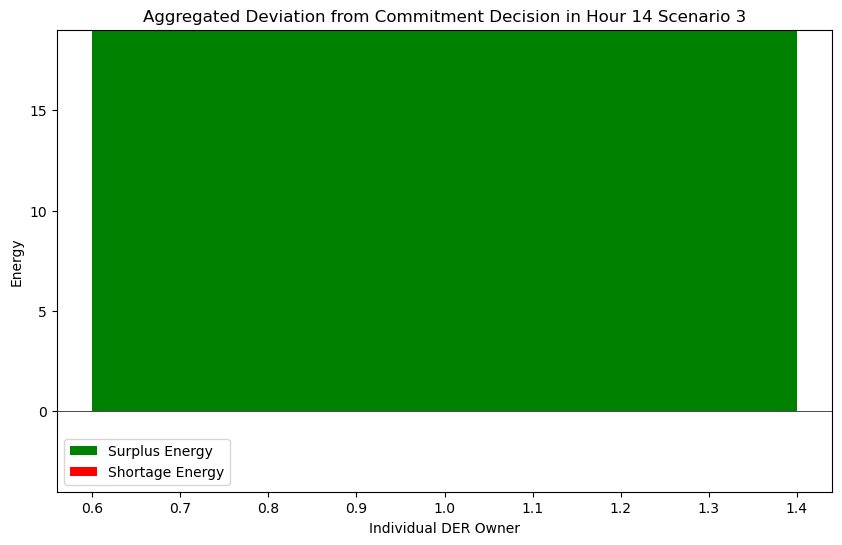

In [38]:
# ✅ 특정 시간과 시나리오 선택
t_target = 14  # 원하는 시간 (예: 13시)
s_target = 3  # 원하는 시나리오 (예: 시나리오 3)

beta_plus_values = beta_plus[t_target, s_target].x
beta_minus_values = [
    -beta_minus[t_target, s_target].x
]  # Shortage는 음수로 변환


# ✅ Figure 설정
fig, ax = plt.subplots(figsize=(10, 6))

# ✅ Surplus (y_plus) -> 초록색
ax.bar(1, beta_plus_values, color="green", label="Surplus Energy")

# ✅ Shortage (y_minus) -> 빨간색
ax.bar(1, beta_minus_values, color="red", label="Shortage Energy")

# ✅ 0 기준선 추가
ax.axhline(0, color="black", linewidth=0.5)

# ✅ 레이블 및 축 설정
ax.set_xlabel("Individual DER Owner")
ax.set_ylabel("Energy")  # DER owner 인덱스 설정
ax.legend()
ax.set_ylim(-4, 19)

# ✅ 제목 추가
plt.title(
    f"Aggregated Deviation from Commitment Decision in Hour {t_target} Scenario {s_target}"
)

# ✅ 그래프 출력
plt.show()

#### 하루 aggregated 커밋량 분석

In [39]:
# 각 시간대 t에 대한 평균 alpha, beta+ 및 beta- 계산 및 출력
for t in range(len(T)):
    avg_alpha = alpha[t].x  # alpha[t]의 최적화 값
    avg_beta_plus = sum(beta_plus[t, s].x for s in range(len(S))) / len(S)  # beta_plus의 평균
    avg_beta_minus = sum(beta_minus[t, s].x for s in range(len(S))) / len(S)  # beta_minus의 평균

    print(f"[시간 {t}] alpha: {avg_alpha:.3f}, beta+: {avg_beta_plus:.3f}, beta-: {avg_beta_minus:.3f}")

# alpha 값의 총합 출력
total_alpha = sum(alpha[t].x for t in range(len(T)))
print(f"총 하루 commitment: {total_alpha:.3f}")

[시간 0] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 1] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 2] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 3] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 4] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 5] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 6] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 7] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 8] alpha: 0.816, beta+: 1.258, beta-: 0.077
[시간 9] alpha: 7.714, beta+: 5.072, beta-: 0.318
[시간 10] alpha: 24.230, beta+: 8.442, beta-: 0.089
[시간 11] alpha: 28.485, beta+: 16.456, beta-: 1.217
[시간 12] alpha: 38.932, beta+: 16.756, beta-: 0.429
[시간 13] alpha: 39.040, beta+: 18.203, beta-: 0.250
[시간 14] alpha: 34.879, beta+: 15.878, beta-: 0.759
[시간 15] alpha: 25.752, beta+: 9.758, beta-: 0.873
[시간 16] alpha: 11.038, beta+: 8.142, beta-: 1.000
[시간 17] alpha: 1.574, beta+: 3.297, beta-: 0.116
[시간 18] alpha: 0.000, beta+: 0.495, beta-: 0.000
[시간 19] alpha: 0.000, beta+: 0.000, beta-: 0.000
[시간 20] alpha: 0.00

### 사후정산

In [40]:
only_value = pd.read_csv('result/result_only_obj.csv').values
only_profit = pd.read_csv('result/result_only_profit.csv').values
surplus = agg.objVal - only_value[0] #

I, T, S = R.shape

R_proportion = R / R.sum(axis=1, keepdims=True) 
R_proportion = np.nan_to_num(R_proportion) 

R_proportion_P = np.multiply(R_proportion, P_DA[:, np.newaxis])

R_weighted = R_proportion_P.sum(axis=(1, 2)) 

R_weighted_normalized = R_weighted / R_weighted.sum() 

surplus_distribution = surplus * R_weighted_normalized  

final_profit = only_profit.flatten() + surplus_distribution

print("Surplus 분배 결과:")
for i, value in enumerate(surplus_distribution):
    print(f"[{i}]: {value:.2f}")

print("\n최종 Profit:")
for i, (profit, only) in enumerate(zip(final_profit, only_profit.flatten())):
    increase_percentage = ((profit - only) / only) * 100
    print(f"[{i}] {profit:.2f} ({increase_percentage:.2f}%)")

Surplus 분배 결과:
[0]: 117.96
[1]: 122.85
[2]: 120.12
[3]: 117.91
[4]: 117.69
[5]: 128.76
[6]: 121.67
[7]: 121.97
[8]: 123.73
[9]: 123.39

최종 Profit:
[0] 1322.48 (9.79%)
[1] 995.40 (14.08%)
[2] 1357.62 (9.71%)
[3] 1246.42 (10.45%)
[4] 841.93 (16.25%)
[5] 1092.27 (13.36%)
[6] 1854.38 (7.02%)
[7] 1220.90 (11.10%)
[8] 892.66 (16.09%)
[9] 1054.06 (13.26%)


### 결과 저장

In [41]:
alpha_df = pd.DataFrame({
    'alpha': [alpha[t].x for t in range(T)]
})
alpha_df.to_csv('result/result_base_alpha.csv', index=False)

# # beta_plus 저장
# beta_plus_df = pd.DataFrame(
#     [[beta_plus[t,s].x for s in range(S)] 
#      for t in range(T)],
#     columns=[f'S{s}' for s in range(S)]
# )
# beta_plus_df.to_csv('result_beta_plus.csv', index=False)

# # beta_minus 저장
# beta_minus_df = pd.DataFrame(
#     [[beta_minus[t,s].x for s in range(S)] 
#      for t in range(T)],
#     columns=[f'S{s}' for s in range(S)]
# )
# beta_minus_df.to_csv('result_beta_minus.csv', index=False)

In [42]:
agg_profit_value = pd.DataFrame({'agg_profit_value': final_profit})
agg_profit_value.to_csv('result/result_agg_profit.csv', index=False)

agg_obj = pd.DataFrame({'agg_obj': [agg.objVal]})
agg_obj.to_csv('result/result_agg_obj.csv', index=False)